<a href="https://colab.research.google.com/github/mateusragazzi/bug-helper/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dependencies

In [1]:
!pip install fastparquet
!pip install python-Levenshtein


##### Imports

In [2]:
from fastparquet import ParquetFile
from google.colab import drive
from datetime import datetime

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import string
import Levenshtein
import matplotlib.pyplot as plt 
import seaborn as sns

import nltk
from nltk.corpus import stopwords
nltk.download('tagsets')
nltk.download('stopwords')

stopwords = stopwords.words('english')

drive.mount('/content/drive')

[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Main Code

#### Read `.parquet` file and separating study cases

In [55]:
parquetFile = ParquetFile('drive/MyDrive/Colab/issues.parquet', verify=True)
pandasDataFrame = parquetFile.to_pandas()

# Filter only bugs
bugDataFrame = pandasDataFrame[pandasDataFrame["issuetype"].str.contains("Bug", na=False)]
# Filter except bugs
baseDataFrame = pandasDataFrame[~pandasDataFrame["issuetype"].str.contains("Bug", na=False)]

#### Statistics for nerds 

In [56]:
### MAIN FUNCTION TO PRINT PERCENTAGE OF ITENS WITH AND WITHOUT SEVERITY
def calculatePercentageOfSeverity(dataFrame):
  itemsWithSeverity = len(dataFrame[~dataFrame['severity'].isnull()])
  itemsWithoutSeverity = len(dataFrame[dataFrame['severity'].isnull()])

  percItemsWithSeverity  = itemsWithSeverity / (itemsWithSeverity + itemsWithoutSeverity)
  percItemsWithoutSeverity  = itemsWithoutSeverity / (itemsWithSeverity + itemsWithoutSeverity)

  print("Percentage with severity is", round(percItemsWithSeverity * 100, 2))
  print("Percentage without severity is", round(percItemsWithoutSeverity * 100, 2))

### MAIN FUNCTION TO PRINT PERCENTAGE OF ITENS WITH AND WITHOUT SEVERITY
def calculatePercentageOfResolutionDate(dataFrame):
  itemsWithResolutionDate = len(dataFrame[~dataFrame['last_resolved'].isnull()])
  itemsWithoutResolutionDate = len(dataFrame[dataFrame['last_resolved'].isnull()])

  percItemsWithResolutionDate  = itemsWithResolutionDate / (itemsWithResolutionDate + itemsWithoutResolutionDate)
  print("Percentage with resolution is", round(percItemsWithResolutionDate * 100, 2))

  percItemsWithoutResolutionDate  = itemsWithoutResolutionDate / (itemsWithResolutionDate + itemsWithoutResolutionDate)
  print("Percentage without resolution is", round(percItemsWithoutResolutionDate * 100, 2))

def clean_string(text):
  if (text is not None):
    text = ' '.join([word for word in text if word not in stopwords])
    text = ''.join([word for word in text if word not in string.punctuation])
    text = text.lower()
    text = text.strip().replace("\n", " ").replace("\r", " ")
    return text
  else:
    return ""

def vetorizarPresencaPalavras(texto, palavraEposicao):
    vetor = [0] * len(palavraEposicao)
    for palavra in texto:
        if palavra in palavraEposicao:
            posicao = palavraEposicao[palavra]
            vetor[posicao] += 1
    return vetor

###### Severity count

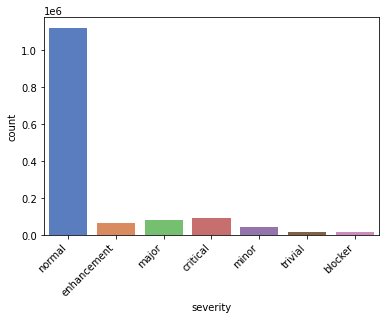

<Figure size 432x288 with 0 Axes>

In [57]:
plot = sns.countplot(x="severity", data=pandasDataFrame, palette='muted')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha="right")
plt.show()
plt.savefig('severity_count')

###### Issue count

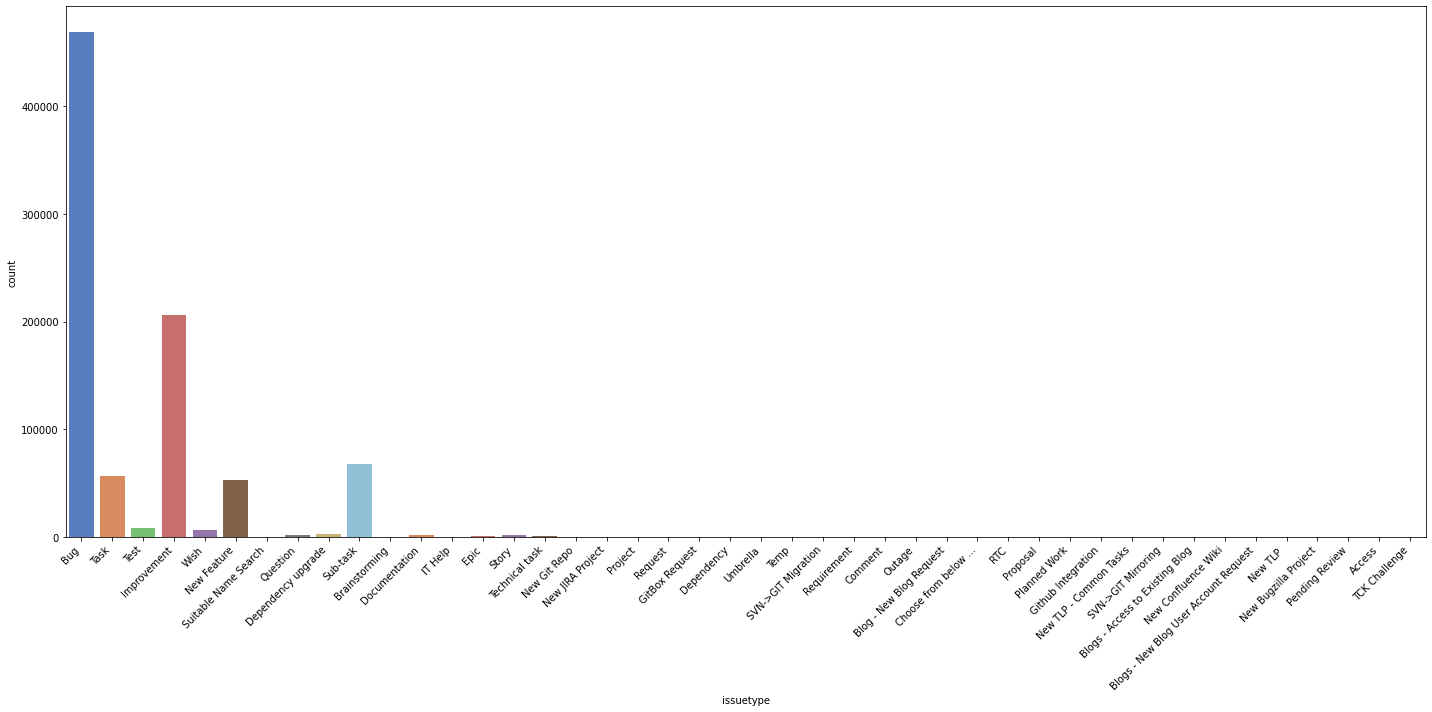

<Figure size 432x288 with 0 Axes>

In [58]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x="issuetype", data=pandasDataFrame, palette='muted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()
plt.savefig('issue_count')

###### Percentage of items resolution date

###### Percentage of items with severity


In [59]:
calculatePercentageOfResolutionDate(pandasDataFrame)

Percentage with resolution is 55.77
Percentage without resolution is 44.23


In [60]:
calculatePercentageOfSeverity(pandasDataFrame)

Percentage with severity is 61.84
Percentage without severity is 38.16


###### Percentage non bugs with severity


In [61]:
calculatePercentageOfSeverity(baseDataFrame)

Percentage with severity is 77.56
Percentage without severity is 22.44


###### Percentage of non Bugs resolution date

In [62]:
calculatePercentageOfResolutionDate(baseDataFrame)

Percentage with resolution is 69.95
Percentage without resolution is 30.05


###### Let's talk about Bugs:

Percentage of Bugs

In [63]:
countOfBugs = len(pandasDataFrame[pandasDataFrame['issuetype'] == 'Bug'])
countNonBugs = len(pandasDataFrame[pandasDataFrame['issuetype'] != 'Bug'])
percOfBugs  = countOfBugs / (countOfBugs + countNonBugs)
percOfNonBugs  = countNonBugs / (countOfBugs + countNonBugs)
print("Percentage of bugs is", round(percOfBugs * 100, 2))
print("Percentage of non bugs is", round(percOfNonBugs * 100, 2))

Percentage of bugs is 20.27
Percentage of non bugs is 79.73


Percentage of Bugs with severity


In [64]:
calculatePercentageOfSeverity(bugDataFrame)

Percentage with severity is 0.0
Percentage without severity is 100.0


Percentage of Bugs resolution date

In [65]:
calculatePercentageOfResolutionDate(bugDataFrame)

Percentage with resolution is 0.0
Percentage without resolution is 100.0


---
> End of statistics
---


#### Balance dataset

In [66]:
baseDataFrame = baseDataFrame[~baseDataFrame['last_resolved'].isnull()]
baseDataFrame = baseDataFrame[~baseDataFrame['severity'].isnull()]

y = baseDataFrame.severity

from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler()

X_resampled, y_resampled = ros.fit_sample(baseDataFrame, y)
os_data_X = pd.DataFrame(data=X_resampled, columns=baseDataFrame.columns)
os_data_y= pd.DataFrame(data=y_resampled, columns=['severity'])

baseDataFrame = pd.DataFrame(X_resampled, columns=baseDataFrame.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#### Validating if balanced has worked

Percentage with severity is 100.0
Percentage without severity is 0.0
Percentage with resolution is 100.0
Percentage without resolution is 0.0


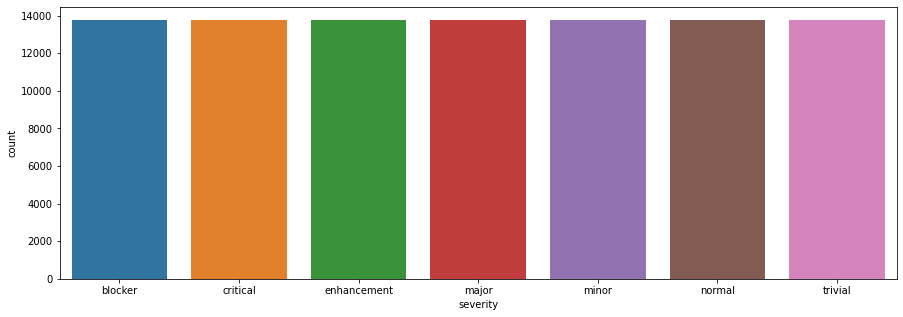

<Figure size 432x288 with 0 Axes>

In [67]:
calculatePercentageOfSeverity(baseDataFrame)
calculatePercentageOfResolutionDate(baseDataFrame)

plt.figure(figsize=(15,5))
ax = sns.countplot(x="severity", data=baseDataFrame)
plt.show()
plt.savefig('issue_count')

In [68]:
print(bugDataFrame.iloc[7279]['summary'])
print('-----')
print(bugDataFrame.iloc[7279]['description'])
print('-----')

Fixing a lot of Flake8 voilations
-----
Either fixing or adding noqa tags in the code, to make sure that we can some day apply flake8 to everything.
-----


#### Training model - Logistic Regression

In [69]:
"""
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(np.ravel(os_data_y))
os_data_y = le.transform(np.ravel(os_data_y))


X = data_final.loc[:, data_final.columns != 'y']
y = data_final.loc[:, data_final.columns == 'y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

le.fit(os_data_X['source'])
os_data_X['source'] = le.transform(os_data_X['source'])

logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y)

print(le.support_)
print(le.ranking_)
"""

"\nfrom sklearn.feature_selection import RFE\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn import preprocessing\n\nle = preprocessing.LabelEncoder()\nle.fit(np.ravel(os_data_y))\nos_data_y = le.transform(np.ravel(os_data_y))\n\n\nX = data_final.loc[:, data_final.columns != 'y']\ny = data_final.loc[:, data_final.columns == 'y']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)\ncolumns = X_train.columns\n\nle.fit(os_data_X['source'])\nos_data_X['source'] = le.transform(os_data_X['source'])\n\nlogreg = LogisticRegression()\nrfe = RFE(logreg, 20)\nrfe = rfe.fit(os_data_X, os_data_y)\n\nprint(le.support_)\nprint(le.ranking_)\n"

#### Training model - Linear Regression

In [70]:
"""
from sklearn.linear_model import LinearRegression

# SPLIT DATASET IN MIDDLE
df1 = baseDataFrame.iloc[:, :48172]
df2 = baseDataFrame.iloc[:, 48172:]

# 1º Tentativa
#df1 = df1.apply(pd.to_numeric, errors='coerce')
#df2 = df2.apply(pd.to_numeric, errors='coerce')

# 2ª Tentativa
# https://stackoverflow.com/questions/34007308/linear-regression-analysis-with-string-categorical-features-variables
# get_dummies estoura a memória
# ----
print(df1.info())

# CREATE A TEST AND TRAIN DATASET's
X_train, X_test, y_train, y_test = train_test_split(df1, df2, test_size=0.3, random_state=0)

clf = LinearRegression().fit(X_train, y_train)
"""

"\nfrom sklearn.linear_model import LinearRegression\n\n# SPLIT DATASET IN MIDDLE\ndf1 = baseDataFrame.iloc[:, :48172]\ndf2 = baseDataFrame.iloc[:, 48172:]\n\n# 1º Tentativa\n#df1 = df1.apply(pd.to_numeric, errors='coerce')\n#df2 = df2.apply(pd.to_numeric, errors='coerce')\n\n# 2ª Tentativa\n# https://stackoverflow.com/questions/34007308/linear-regression-analysis-with-string-categorical-features-variables\n# get_dummies estoura a memória\n# ----\nprint(df1.info())\n\n# CREATE A TEST AND TRAIN DATASET's\nX_train, X_test, y_train, y_test = train_test_split(df1, df2, test_size=0.3, random_state=0)\n\nclf = LinearRegression().fit(X_train, y_train)\n"

#### Testando classificação de texto

In [78]:
# MERGING TWO CELL's FOR BETTER MANAGMENT
baseDataFrame['summary'] = baseDataFrame['summary'].astype(str).str.lower()
baseDataFrame['description'] = baseDataFrame['description'].astype(str).str.lower()

baseDataFrame['text'] = baseDataFrame['summary'].astype(str) + baseDataFrame['description'].astype(str)

# MAKING COPY TO AVOID MEMORY LIMIT
df1 = baseDataFrame

"""
baseDataFrame['text'] = baseDataFrame['summary'].astype(str).str.split() + baseDataFrame['description'].astype(str).str.split()

dictionary = set()
for words in baseDataFrame['text']:
  dictionary.update(words)

quantityOfWords = len(dictionary)

wordsAndDict = dict(zip(dictionary, range(quantityOfWords)))

texto = baseDataFrame['text'][0]
print(texto)
print(wordsAndDict)
print(vetorizarPresencaPalavras(texto, wordsAndDict))
"""
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(df1['text'])
# vectorizer.vocabulary_


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=False, max_df=1.0, max_features=None, min_df=0,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [79]:
# Estoura a memória

sentences = df1['text'].values
y = df1['severity'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.4, random_state=1000)


In [80]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<57808x40281 sparse matrix of type '<class 'numpy.int64'>'
	with 523187 stored elements in Compressed Sparse Row format>

In [81]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.4526984950700571


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Get one item from bug to analise and clean phrase

In [75]:
focusedItem = bugDataFrame.iloc[3489]['summary']
# focusedItem = "Cannot edit settings under Edit Preferences"
focusedItem = clean_string(focusedItem)

print(focusedItem)

e r r r   u b n g   h e   j b     h   l g n 1  l 4  c c  u e x    e u   e g e    2


#### Search the closest item inside base dataframe

In [76]:
minDistance = 0;
betterIndex = 0;

for index, row in baseDataFrame.iterrows():
  phrase = clean_string(row['summary'])  
  distance = Levenshtein.distance(focusedItem, phrase)

  if (index == 0):
    minDistance = distance
    betterIndex = index
  
  elif (distance <= minDistance) :
    minDistance = distance
    betterIndex = index

print("better index: ", betterIndex)
print("min distance: ", minDistance)

better index:  75816
min distance:  27


#### Printing the severity and days to resolved

In [77]:
item = baseDataFrame.loc[betterIndex]

severity = item['severity']
created = item['created']
last_resolved = item['last_resolved']

print(created)
print(last_resolved)

resolvedTime = (str) ((last_resolved - created).days)

if (resolvedTime is None):
  resolvedTime = "0"

if (severity is None):
  severity = "unknown"

print("Your problem has a " + severity + " severity and will take " + resolvedTime + " day(s) to resolve")

2019-10-14 05:40:56
2019-10-14 15:34:29
Your problem has a normal severity and will take 0 day(s) to resolve
